Report: https://docs.google.com/document/d/1xDP_mJxwfrVfA2fm8wvBsaL2tg1oUL1IbIXLtrkPpCQ/edit#<br />
Suggestions: weizhong.goh at gmail.com

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [73]:
c_big = pd.read_csv('train.csv')

In [888]:
c_big[c_big.Score.isnull()].index

Int64Index([460804, 460805, 460806, 460807, 460808, 460809, 460810, 460811,
            460812, 460813,
            ...
            560794, 560795, 560796, 560797, 560798, 560799, 560800, 560801,
            560802, 560803],
           dtype='int64', length=100000)

In [3]:
list(c_big.columns)

['HelpfulnessDenominator',
 'HelpfulnessNumerator',
 'Id',
 'ProductId',
 'Score',
 'Summary',
 'Text',
 'Time',
 'UserId']

In [64]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(c_big[c_big.Score.notnull()])

## Other reviews of the same product (if std is small): Not included in final classifier

In [701]:
c_big.groupby('ProductId').Score.std()[c_big.groupby('ProductId').Score.count() > 20].describe()

count    3809.000000
mean        1.186103
std         0.329943
min         0.000000
25%         0.973795
50%         1.201119
75%         1.430535
max         1.965173
Name: Score, dtype: float64

In [ ]:
d = c_big[c_big.Score.notnull()]

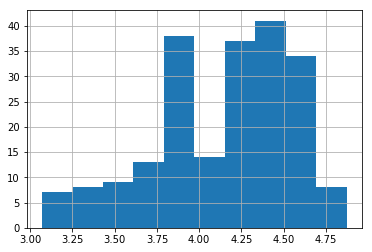

In [83]:
d[d.ProductId.isin(d.ProductId.value_counts()[d.ProductId.value_counts() > 200].index)].groupby('ProductId').Score.mean().hist()
plt.show()

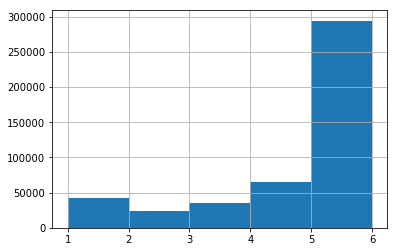

In [32]:
d.Score.hist(bins=[1,2,3,4,5,6])
plt.show()

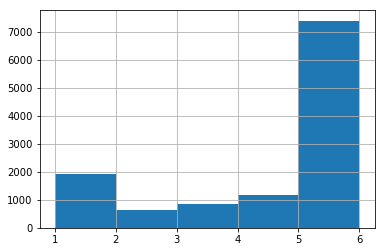

In [64]:
d[d.HelpfulnessNumerator>10].Score.hist(bins=[1,2,3,4,5,6])
plt.show()

In [ ]:
prod_counts = c_big.loc[train.index].groupby('ProductId').Score.count()

In [607]:
prod_sums = c_big.loc[train.index].groupby('ProductId').Score.sum()

ProductId
0006641040    105.0
141278509X      5.0
2734888454      7.0
2841233731      5.0
7310172001    534.0
7310172101    494.0
7800648702      3.0
B00002N8SM     44.0
B00002NCJC      5.0
B00002Z754      5.0
B00004CI84    525.0
B00004CXX9    513.0
B00004RAMS     84.0
B00004RAMV     12.0
B00004RAMX     58.0
B00004RAMY    410.0
B00004RBDU    225.0
B00004RBDW     81.0
B00004RBDZ    131.0
B00004RYGX    462.0
B00004S1C5     53.0
B00004S1C6    187.0
B000052Y74     13.0
B00005344V     30.0
B0000537KC     36.0
B00005C2M2    149.0
B00005C2M3     12.0
B00005IX96     32.0
B00005IX97     29.0
B00005IX98     25.0
              ...  
B009M6W5UQ      5.0
B009MRNOR8      1.0
B009NEQAHQ      4.0
B009NIF7BM     10.0
B009NTCO4O     34.0
B009NTCP6Q      4.0
B009NWIF3A     10.0
B009NY1MC4     78.0
B009O0U2SW     10.0
B009O753WA      5.0
B009O7B1I0      1.0
B009O7DGEW      5.0
B009OM65GI      5.0
B009OM65H2     10.0
B009OM66IU      5.0
B009OY38SY      5.0
B009PCDDO4      5.0
B009PFJUF2     10.0
B009PG8MVO

In [613]:
prod_sum_squares = c_big.loc[train.index].groupby('ProductId').Score.agg(lambda x: sum(np.square(x)))

In [671]:
def calculate_mean_other_reviews_same_product_nt(ProductId):
    try:
        return (prod_sums.loc[ProductId])/(prod_counts.loc[ProductId])
    except KeyError:
        return np.nan
    
def calculate_std_other_reviews_same_product_nt(ProductId):
    try:
        mean_other_reviews = (prod_sums.loc[ProductId])/(prod_counts.loc[ProductId])
        return np.sqrt((prod_sum_squares.loc[ProductId] - mean_other_reviews**2*(prod_counts.loc[ProductId]))/(prod_counts.loc[ProductId] - 1))
    except KeyError:
        return np.nan

def calculate_mean_other_reviews_same_product_t(ProductId, Score):
    try:
        return (prod_sums.loc[ProductId] - Score)/(prod_counts.loc[ProductId] - 1)
    except KeyError:
        return np.nan
    
def calculate_std_other_reviews_same_product_t(ProductId, Score):
    try:
        mean_other_reviews = (prod_sums.loc[ProductId] - Score)/(prod_counts.loc[ProductId] - 1)
        return np.sqrt((prod_sum_squares.loc[ProductId] - Score**2 - mean_other_reviews**2*(prod_counts.loc[ProductId] - 1))/(prod_counts.loc[ProductId] - 1 - 1))
    except KeyError:
        return np.nan

In [703]:
def calculate_count_other_reviews_same_product(ProductId, is_train):
    try:
        return prod_counts.loc[ProductId] - is_train
    except KeyError:
        return np.nan

c_big['count_other_reviews_same_product'] = c_big.ProductId.apply(lambda ProductId: calculate_count_other_reviews_same_product(ProductId, 0))
c_big.loc[train.index]['count_other_reviews_same_product'] = c_big.loc[train.index].ProductId.apply(lambda ProductId: calculate_count_other_reviews_same_product(ProductId, 1))

In [687]:
c_big['mean_other_reviews_same_product'] = c_big.ProductId.apply(calculate_mean_other_reviews_same_product_nt)
c_big['std_other_reviews_same_product'] = c_big.ProductId.apply(calculate_std_other_reviews_same_product_nt)
c_big.loc[train.index]['mean_other_reviews_same_product'] = c_big.loc[train.index].apply(lambda row: calculate_mean_other_reviews_same_product_t(row.ProductId, row.Score), axis=1)
c_big.loc[train.index]['std_other_reviews_same_product'] = c_big.loc[train.index].apply(lambda row: calculate_std_other_reviews_same_product_t(row.ProductId, row.Score), axis=1)

C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [721]:
c_big['adj_mean_other_reviews_same_product'] = c_big.apply(lambda row: row.mean_other_reviews_same_product 
    if ((row.count_other_reviews_same_product > 20) & (row.std_other_reviews_same_product < 0.8)) else 4.170267, axis=1)

In [723]:
c_big['adj_std_other_reviews_same_product'] = c_big.apply(lambda row: row.std_other_reviews_same_product 
    if ((row.count_other_reviews_same_product > 20) & (row.std_other_reviews_same_product < 0.8)) else 4, axis=1)

In [689]:
c_big['mean_other_reviews_same_product'].fillna(4.170267, inplace=True) # 4.17 is c_big.groupby('ProductId').Score.mean().describe()
c_big['std_other_reviews_same_product'].fillna(4, inplace=True)

## Review length

In [65]:
c_big['review_length'] = c_big.Text.apply(len)
train['review_length'] = train.Text.apply(len)

AttributeError: 'DataFrame' object has no attribute 'Text'

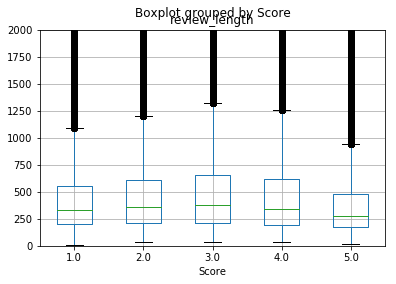

In [53]:
c_big.boxplot(column='review_length', by='Score')
plt.ylim([0,2000])
plt.show()

## Process review text

In [6]:
tophalf, bottomhalf = train_test_split(train.index, test_size=0.5)
indexpool = [[], [], [], []]
indexpool[0], indexpool[1] = train_test_split(tophalf, test_size=0.5)
indexpool[2], indexpool[3] = train_test_split(bottomhalf, test_size=0.5)

In [374]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

stemmer = SnowballStemmer("english")

Go get some coffee. The following step takes a while. 

In [266]:
c_big['review_stemmed'] = c_big.Text.apply(lambda text: " ".join([stemmer.stem(x) for x in word_tokenize(text)]))

In [377]:
c_big['summary_stemmed'] = c_big[c_big.Summary.notnull()].Summary.apply(lambda text: " ".join([stemmer.stem(x) for x in word_tokenize(text)]))

In [290]:
good_v_bad = [[], [], [], []]

for i in range(4):
    good_review_onegrams = ' '.join(c_big.loc[indexpool[i]][c_big.Score == 5].review_stemmed).split()
    bad_review_onegrams = ' '.join(c_big.loc[indexpool[i]][c_big.Score <= 2].review_stemmed).split()
    good_review_words = pd.Series(good_review_onegrams).value_counts(normalize=True)
    bad_review_words = pd.Series(bad_review_onegrams).value_counts(normalize=True)
    good_v_bad[i] = pd.concat([good_review_words, bad_review_words], axis=1, join='outer').fillna(0)
    good_v_bad[i]['ratio'] = (good_v_bad[i][0]+1e-6)/(good_v_bad[i][1]+1e-6)

C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [397]:
c_big.summary_stemmed[c_big.summary_stemmed.isnull()] = ''

C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [398]:
s_good_v_bad = [[], [], [], []]

for i in range(4):
    good_review_onegrams = ' '.join(c_big.loc[indexpool[i]][c_big.Score == 5].summary_stemmed).split()
    bad_review_onegrams = ' '.join(c_big.loc[indexpool[i]][c_big.Score <= 2].summary_stemmed).split()
    good_review_words = pd.Series(good_review_onegrams).value_counts(normalize=True)
    bad_review_words = pd.Series(bad_review_onegrams).value_counts(normalize=True)
    s_good_v_bad[i] = pd.concat([good_review_words, bad_review_words], axis=1, join='outer').fillna(0)
    s_good_v_bad[i]['ratio'] = (s_good_v_bad[i][0]+1e-6)/(s_good_v_bad[i][1]+1e-6)

C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [264]:
from nltk.util import ngrams

td_good_v_bad = [[], [], [], []]

for i in range(4):
    x = c_big.loc[indexpool[i]][c_big.Score == 5].review_stemmed.str.split().apply(lambda x: list(ngrams(x, 2))).ravel()
    y = c_big.loc[indexpool[i]][c_big.Score <= 2].review_stemmed.str.split().apply(lambda x: list(ngrams(x, 2))).ravel()
    good_review_words = pd.Series([item for sublist in x for item in sublist]).value_counts(normalize=True)
    bad_review_words = pd.Series([item for sublist in y for item in sublist]).value_counts(normalize=True)
    td_good_v_bad[i] = pd.concat([good_review_words, bad_review_words], axis=1, join='outer').fillna(0)
    td_good_v_bad[i]['ratio'] = (td_good_v_bad[i][0]+1e-6)/(td_good_v_bad[i][1]+1e-6)

C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [929]:
td_middle_v_rest = [[], [], [], []]

for i in range(4):
    x = c_big.loc[indexpool[i]][(c_big.Score == 3) | (c_big.Score == 4)].review_stemmed.str.split().apply(lambda x: list(ngrams(x, 2))).ravel()
    y = c_big.loc[indexpool[i]][(c_big.Score <= 2) | (c_big.Score == 5)].review_stemmed.str.split().apply(lambda x: list(ngrams(x, 2))).ravel()
    middle_review_words = pd.Series([item for sublist in x for item in sublist]).value_counts(normalize=True)
    rest_review_words = pd.Series([item for sublist in y for item in sublist]).value_counts(normalize=True)
    td_middle_v_rest[i] = pd.concat([middle_review_words, rest_review_words], axis=1, join='outer').fillna(0)
    td_middle_v_rest[i]['ratio'] = (td_middle_v_rest[i][0]+1e-6)/(td_middle_v_rest[i][1]+1e-6)

C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [71]:
from nltk.util import ngrams

td_freq = [[], [], [], [], [], []]

from sklearn.model_selection import KFold

kf = KFold(n_splits=6)

for i, (_, indices) in enumerate(kf.split(train.index)):

    a = c_big.loc[indices][c_big.Score == 1].review_stemmed.str.split().apply(lambda x: list(ngrams(x, 2))).ravel()
    b = c_big.loc[indices][c_big.Score == 2].review_stemmed.str.split().apply(lambda x: list(ngrams(x, 2))).ravel()
    c = c_big.loc[indices][c_big.Score == 3].review_stemmed.str.split().apply(lambda x: list(ngrams(x, 2))).ravel()
    d = c_big.loc[indices][c_big.Score == 4].review_stemmed.str.split().apply(lambda x: list(ngrams(x, 2))).ravel()
    e = c_big.loc[indices][c_big.Score == 5].review_stemmed.str.split().apply(lambda x: list(ngrams(x, 2))).ravel()
    a_count = pd.Series([item for sublist in a for item in sublist]).count()
    b_count = pd.Series([item for sublist in b for item in sublist]).count()
    c_count = pd.Series([item for sublist in c for item in sublist]).count()
    d_count = pd.Series([item for sublist in d for item in sublist]).count()
    e_count = pd.Series([item for sublist in e for item in sublist]).count()
    a_freq = pd.Series([item for sublist in a for item in sublist]).value_counts()
    b_freq = pd.Series([item for sublist in b for item in sublist]).value_counts()
    c_freq = pd.Series([item for sublist in c for item in sublist]).value_counts()
    d_freq = pd.Series([item for sublist in d for item in sublist]).value_counts()
    e_freq = pd.Series([item for sublist in e for item in sublist]).value_counts()
    td_freq[i] = pd.concat([a_freq, b_freq, c_freq, d_freq, e_freq], axis=1, join='outer').fillna(0)
    td_freq[i]['ratio_1_rest'] = (td_freq[i][0]/a_count+1e-4)/((td_freq[i][1]+td_freq[i][2]+td_freq[i][3]+td_freq[i][4])/(b_count+c_count+d_count+e_count)+1e-4)
    td_freq[i]['ratio_2_rest'] = (td_freq[i][1]/b_count+1e-4)/((td_freq[i][0]+td_freq[i][2]+td_freq[i][3]+td_freq[i][4])/(a_count+c_count+d_count+e_count)+1e-4)
    td_freq[i]['ratio_3_rest'] = (td_freq[i][2]/c_count+1e-4)/((td_freq[i][0]+td_freq[i][1]+td_freq[i][3]+td_freq[i][4])/(a_count+b_count+d_count+e_count)+1e-4)
    td_freq[i]['ratio_4_rest'] = (td_freq[i][3]/d_count+1e-4)/((td_freq[i][0]+td_freq[i][1]+td_freq[i][2]+td_freq[i][4])/(a_count+b_count+c_count+e_count)+1e-4)
    td_freq[i]['ratio_5_rest'] = (td_freq[i][4]/e_count+1e-4)/((td_freq[i][0]+td_freq[i][1]+td_freq[i][2]+td_freq[i][3])/(a_count+b_count+c_count+d_count)+1e-4)
    td_freq[i]['ratio_1_rest_ms'] = (td_freq[i][0]/a_count+1e-6)/((td_freq[i][1]+td_freq[i][2]+td_freq[i][3]+td_freq[i][4])/(b_count+c_count+d_count+e_count)+1e-6)
    td_freq[i]['ratio_2_rest_ms'] = (td_freq[i][1]/b_count+1e-6)/((td_freq[i][0]+td_freq[i][2]+td_freq[i][3]+td_freq[i][4])/(b_count+c_count+d_count+e_count)+1e-6)
    td_freq[i]['ratio_3_rest_ms'] = (td_freq[i][2]/c_count+1e-6)/((td_freq[i][0]+td_freq[i][1]+td_freq[i][3]+td_freq[i][4])/(b_count+c_count+d_count+e_count)+1e-6)
    td_freq[i]['ratio_4_rest_ms'] = (td_freq[i][3]/d_count+1e-6)/((td_freq[i][0]+td_freq[i][1]+td_freq[i][2]+td_freq[i][4])/(b_count+c_count+d_count+e_count)+1e-6)
    td_freq[i]['ratio_5_rest_ms'] = (td_freq[i][4]/e_count+1e-6)/((td_freq[i][0]+td_freq[i][1]+td_freq[i][2]+td_freq[i][3])/(b_count+c_count+d_count+e_count)+1e-6)

C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [504]:
from nltk.util import ngrams

sd_good_v_bad = [[], [], [], []]

for i in range(4):
    x = c_big.loc[indexpool[i]][c_big.Score == 5].summary_stemmed.str.split().apply(lambda x: list(ngrams(x, 2))).ravel()
    y = c_big.loc[indexpool[i]][c_big.Score <= 2].summary_stemmed.str.split().apply(lambda x: list(ngrams(x, 2))).ravel()
    good_review_words = pd.Series([item for sublist in x for item in sublist]).value_counts(normalize=True)
    bad_review_words = pd.Series([item for sublist in y for item in sublist]).value_counts(normalize=True)
    sd_good_v_bad[i] = pd.concat([good_review_words, bad_review_words], axis=1, join='outer').fillna(0)
    sd_good_v_bad[i]['ratio'] = (sd_good_v_bad[i][0]+1e-6)/(sd_good_v_bad[i][1]+1e-6)

C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: generator 'ngrams' raised StopIteration


In [750]:
from nltk.util import ngrams

tt_good_v_bad = [[], [], [], []]

for i in range(4):
    x = c_big.loc[indexpool[i]][c_big.Score == 5].review_stemmed.str.split().apply(lambda x: list(ngrams(x, 3))).ravel()
    y = c_big.loc[indexpool[i]][c_big.Score <= 2].review_stemmed.str.split().apply(lambda x: list(ngrams(x, 3))).ravel()
    good_review_words = pd.Series([item for sublist in x for item in sublist]).value_counts(normalize=True)
    bad_review_words = pd.Series([item for sublist in y for item in sublist]).value_counts(normalize=True)
    tt_good_v_bad[i] = pd.concat([good_review_words, bad_review_words], axis=1, join='outer').fillna(0)
    tt_good_v_bad[i]['ratio'] = (tt_good_v_bad[i][0]+1e-6)/(tt_good_v_bad[i][1]+1e-6)

C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [916]:
import gc
gc.collect()

tf_good_v_bad = [[], [], [], []]

for i in range(4):
    x = c_big.loc[indexpool[i]][c_big.Score == 5].review_stemmed.str.split().apply(lambda x: list(ngrams(x, 4))).ravel()
    y = c_big.loc[indexpool[i]][c_big.Score <= 2].review_stemmed.str.split().apply(lambda x: list(ngrams(x, 4))).ravel()
    good_review_words = pd.Series([item for sublist in x for item in sublist]).value_counts(normalize=True)
    bad_review_words = pd.Series([item for sublist in y for item in sublist]).value_counts(normalize=True)
    del x
    del y
    gc.collect()
    tf_good_v_bad[i] = pd.concat([good_review_words[good_review_words>0.000001], bad_review_words[bad_review_words>0.000001]], axis=1, join='outer').fillna(0)
    tf_good_v_bad[i]['ratio'] = (tf_good_v_bad[i][0]+1e-6)/(tf_good_v_bad[i][1]+1e-6)

C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
good_v_bad_all = pd.concat([good_v_bad[i]['ratio'] for i in range(4)], axis=1)
good_v_bad_all.columns = ['r1', 'r2', 'r3', 'r4']
selection = ((good_v_bad_all.r1 > 1) & (good_v_bad_all.r2 > 1) & (good_v_bad_all.r3 > 1) & (good_v_bad_all.r4 > 1)) | ((good_v_bad_all.r1 < 1) & (good_v_bad_all.r2 < 1) & (good_v_bad_all.r3 < 1) & (good_v_bad_all.r4 < 1))
good_v_bad_all = good_v_bad_all[selection]
good_v_bad_all['weight'] = good_v_bad_all.mean(axis=1)

In [399]:
s_good_v_bad_all = pd.concat([s_good_v_bad[i]['ratio'] for i in range(4)], axis=1)
s_good_v_bad_all.columns = ['r1', 'r2', 'r3', 'r4']
selection = ((s_good_v_bad_all.r1 > 1) & (s_good_v_bad_all.r2 > 1) & (s_good_v_bad_all.r3 > 1) & (s_good_v_bad_all.r4 > 1)) | ((s_good_v_bad_all.r1 < 1) & (s_good_v_bad_all.r2 < 1) & (s_good_v_bad_all.r3 < 1) & (s_good_v_bad_all.r4 < 1))
s_good_v_bad_all = s_good_v_bad_all[selection]
s_good_v_bad_all['weight'] = s_good_v_bad_all.mean(axis=1)

In [505]:
sd_good_v_bad_all = pd.concat([sd_good_v_bad[i]['ratio'] for i in range(4)], axis=1)
sd_good_v_bad_all.columns = ['r1', 'r2', 'r3', 'r4']
selection = ((sd_good_v_bad_all.r1 > 1) & (sd_good_v_bad_all.r2 > 1) & (sd_good_v_bad_all.r3 > 1) & (sd_good_v_bad_all.r4 > 1)) | ((sd_good_v_bad_all.r1 < 1) & (sd_good_v_bad_all.r2 < 1) & (sd_good_v_bad_all.r3 < 1) & (sd_good_v_bad_all.r4 < 1))
sd_good_v_bad_all = sd_good_v_bad_all[selection]
sd_good_v_bad_all['weight'] = sd_good_v_bad_all.mean(axis=1)

In [265]:
td_good_v_bad_all = pd.concat([td_good_v_bad[i]['ratio'] for i in range(4)], axis=1)
td_good_v_bad_all.columns = ['r1', 'r2', 'r3', 'r4']
selection = ((td_good_v_bad_all.r1 > 1) & (td_good_v_bad_all.r2 > 1) & (td_good_v_bad_all.r3 > 1) & (td_good_v_bad_all.r4 > 1)) | ((td_good_v_bad_all.r1 < 1) & (td_good_v_bad_all.r2 < 1) & (td_good_v_bad_all.r3 < 1) & (td_good_v_bad_all.r4 < 1))
td_good_v_bad_all = td_good_v_bad_all[selection]
td_good_v_bad_all['weight'] = td_good_v_bad_all.mean(axis=1)

In [931]:
td_middle_v_rest_all = pd.concat([td_middle_v_rest[i]['ratio'] for i in range(4)], axis=1)
td_middle_v_rest_all.columns = ['r1', 'r2', 'r3', 'r4']
selection = ((td_middle_v_rest_all.r1 > 1) & (td_middle_v_rest_all.r2 > 1) & (td_middle_v_rest_all.r3 > 1) & (td_middle_v_rest_all.r4 > 1)) | ((td_middle_v_rest_all.r1 < 1) & (td_middle_v_rest_all.r2 < 1) & (td_middle_v_rest_all.r3 < 1) & (td_middle_v_rest_all.r4 < 1))
td_middle_v_rest_all = td_middle_v_rest_all[selection]
td_middle_v_rest_all['weight'] = td_middle_v_rest_all.mean(axis=1)

In [72]:
td_freq_all = [[], [], [], [], [], [], [], [], [], []]
for j, col_name in enumerate(['ratio_1_rest', 'ratio_2_rest', 'ratio_3_rest', 'ratio_4_rest', 'ratio_5_rest',
                             'ratio_1_rest_ms', 'ratio_2_rest_ms', 'ratio_3_rest_ms', 'ratio_4_rest_ms', 'ratio_5_rest_ms']):
    td_freq_all[j] = pd.concat([td_freq[i][col_name] for i in range(6)], axis=1)
    td_freq_all[j].columns = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6']
    selection =   (td_freq_all[j].r1 > 1) & (td_freq_all[j].r2 > 1) & (td_freq_all[j].r3 > 1) \
                & (td_freq_all[j].r4 > 1) & (td_freq_all[j].r5 > 1) & (td_freq_all[j].r6 > 1)
    td_freq_all[j] = td_freq_all[j][selection]
    td_freq_all[j]['weight'] = td_freq_all[j].mean(axis=1)

In [12]:
td_freq_combined = pd.concat([td_freq_all[i]['weight'] for i in range(10)], axis=1)
td_freq_combined.columns = ['weight_1', 'weight_2', 'weight_3', 'weight_4', 'weight_5', 'weight_1_ms', 'weight_2_ms', 'weight_3_ms', 'weight_4_ms', 'weight_5_ms']
td_freq_combined.fillna(0, inplace=True)

In [751]:
tt_good_v_bad_all = pd.concat([tt_good_v_bad[i]['ratio'] for i in range(4)], axis=1)
tt_good_v_bad_all.columns = ['r1', 'r2', 'r3', 'r4']
selection = ((tt_good_v_bad_all.r1 > 1) & (tt_good_v_bad_all.r2 > 1) & (tt_good_v_bad_all.r3 > 1) & (tt_good_v_bad_all.r4 > 1)) | ((tt_good_v_bad_all.r1 < 1) & (tt_good_v_bad_all.r2 < 1) & (tt_good_v_bad_all.r3 < 1) & (tt_good_v_bad_all.r4 < 1))
tt_good_v_bad_all = tt_good_v_bad_all[selection]
tt_good_v_bad_all['weight'] = tt_good_v_bad_all.mean(axis=1)

In [917]:
tf_good_v_bad_all = pd.concat([tf_good_v_bad[i]['ratio'] for i in range(4)], axis=1)
tf_good_v_bad_all.columns = ['r1', 'r2', 'r3', 'r4']
selection = ((tf_good_v_bad_all.r1 > 1) & (tf_good_v_bad_all.r2 > 1) & (tf_good_v_bad_all.r3 > 1) & (tf_good_v_bad_all.r4 > 1)) | ((tf_good_v_bad_all.r1 < 1) & (tf_good_v_bad_all.r2 < 1) & (tf_good_v_bad_all.r3 < 1) & (tf_good_v_bad_all.r4 < 1))
tf_good_v_bad_all = tf_good_v_bad_all[selection]
tf_good_v_bad_all['weight'] = tf_good_v_bad_all.mean(axis=1)

In [320]:
good_v_bad_all['pos_weight'] = good_v_bad_all[good_v_bad_all['weight']>1]['weight']
good_v_bad_all['neg_weight'] = -1/good_v_bad_all[good_v_bad_all['weight']<1]['weight']
good_v_bad_all.fillna(0, inplace=True)

In [400]:
s_good_v_bad_all['pos_weight'] = s_good_v_bad_all[s_good_v_bad_all['weight']>1]['weight']
s_good_v_bad_all['neg_weight'] = -1/s_good_v_bad_all[s_good_v_bad_all['weight']<1]['weight']
s_good_v_bad_all.fillna(0, inplace=True)

In [507]:
sd_good_v_bad_all['pos_weight'] = sd_good_v_bad_all[sd_good_v_bad_all['weight']>1]['weight']
sd_good_v_bad_all['neg_weight'] = -1/sd_good_v_bad_all[sd_good_v_bad_all['weight']<1]['weight']
sd_good_v_bad_all.fillna(0, inplace=True)

In [736]:
td_good_v_bad_all['pos_weight'] = td_good_v_bad_all[td_good_v_bad_all['weight']>1]['weight']
td_good_v_bad_all['neg_weight'] = -1/td_good_v_bad_all[td_good_v_bad_all['weight']<1]['weight']
td_good_v_bad_all.fillna(0, inplace=True)

In [932]:
td_middle_v_rest_all['middle_weight'] = td_middle_v_rest_all[td_middle_v_rest_all['weight']>1]['weight']
td_middle_v_rest_all['rest_weight'] = -1/td_middle_v_rest_all[td_middle_v_rest_all['weight']<1]['weight']
td_middle_v_rest_all.fillna(0, inplace=True)

In [752]:
tt_good_v_bad_all['pos_weight'] = tt_good_v_bad_all[tt_good_v_bad_all['weight']>1]['weight']
tt_good_v_bad_all['neg_weight'] = -1/tt_good_v_bad_all[tt_good_v_bad_all['weight']<1]['weight']
tt_good_v_bad_all.fillna(0, inplace=True)

In [918]:
tf_good_v_bad_all['pos_weight'] = tf_good_v_bad_all[tf_good_v_bad_all['weight']>1]['weight']
tf_good_v_bad_all['neg_weight'] = -1/tf_good_v_bad_all[tf_good_v_bad_all['weight']<1]['weight']
tf_good_v_bad_all.fillna(0, inplace=True)

In [286]:
good_v_bad = pd.concat([good_review_words, bad_review_words], axis=1, join='outer').fillna(0)
good_v_bad['ratio'] = (good_v_bad[0]+1e-6)/(good_v_bad[1]+1e-6)
good_v_bad['sum'] = good_v_bad[0]+good_v_bad[1]
good_v_bad['weight'] = good_v_bad['ratio'].apply(lambda x: x if x > 1 else 1/(x)) 

In [322]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2), vocabulary=good_v_bad_all.index)
#vectorizer.fit(c_big.review_stemmed.loc[train.index])
dtm_text = vectorizer.transform(c_big.review_stemmed)

In [402]:
s_vectorizer = CountVectorizer(vocabulary=s_good_v_bad_all.index)
#vectorizer.fit(c_big.review_stemmed.loc[train.index])
s_dtm_text = s_vectorizer.transform(c_big.summary_stemmed)

In [523]:
sd_vectorizer = CountVectorizer(ngram_range=(2,2), vocabulary=[' '.join(x) for x in list(sd_good_v_bad_all.index)])
#vectorizer.fit(c_big.review_stemmed.loc[train.index])
sd_dtm_text = sd_vectorizer.transform(c_big.summary_stemmed)

In [740]:
td_vectorizer = CountVectorizer(ngram_range=(2,2), vocabulary=[' '.join(x) for x in list(td_good_v_bad_all.index)])
#vectorizer.fit(c_big.review_stemmed.loc[train.index])
td_dtm_text = td_vectorizer.transform(c_big.review_stemmed)

In [935]:
tdm_vectorizer = CountVectorizer(ngram_range=(2,2), vocabulary=[' '.join(x) for x in list(td_middle_v_rest_all.index)])
#vectorizer.fit(c_big.review_stemmed.loc[train.index])
tdm_dtm_text = tdm_vectorizer.transform(c_big.review_stemmed)

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
tds_vectorizer = CountVectorizer(ngram_range=(2,2), vocabulary=[' '.join(x) for x in list(td_freq_combined.index)])
#vectorizer.fit(c_big.review_stemmed.loc[train.index])
tds_dtm_text = tds_vectorizer.transform(c_big.review_stemmed)

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
tde_vectorizer = CountVectorizer(ngram_range=(2,2), vocabulary=['two star', '2 star', 'three star', '3 star', 'four star', '4 star', 'star off'])
#vectorizer.fit(c_big.review_stemmed.loc[train.index])
tde_dtm_text = tde_vectorizer.transform(c_big.review_stemmed)

In [759]:
tt_vectorizer = CountVectorizer(ngram_range=(3,3), vocabulary=[' '.join(x) for x in list(tt_good_v_bad_all.index)])
#vectorizer.fit(c_big.review_stemmed.loc[train.index])
tt_dtm_text = tt_vectorizer.transform(c_big.review_stemmed)

In [ ]:
tf_vectorizer = CountVectorizer(ngram_range=(3,3), vocabulary=[' '.join(x) for x in list(tf_good_v_bad_all.index)])
#vectorizer.fit(c_big.review_stemmed.loc[train.index])
tf_dtm_text = tf_vectorizer.transform(c_big.review_stemmed)

In [325]:
c_big['pos_score'] = dtm_text.dot(good_v_bad_all.pos_weight)
c_big['neg_score'] = dtm_text.dot(good_v_bad_all.neg_weight)

In [403]:
c_big['s_pos_score'] = s_dtm_text.dot(s_good_v_bad_all.pos_weight)
c_big['s_neg_score'] = s_dtm_text.dot(s_good_v_bad_all.neg_weight)

In [525]:
c_big['sd_pos_score'] = sd_dtm_text.dot(sd_good_v_bad_all.pos_weight)
c_big['sd_neg_score'] = sd_dtm_text.dot(sd_good_v_bad_all.neg_weight)

In [741]:
c_big['td_pos_score'] = td_dtm_text.dot(td_good_v_bad_all.pos_weight)
c_big['td_neg_score'] = td_dtm_text.dot(td_good_v_bad_all.neg_weight)

In [937]:
c_big['td_middle_score'] = tdm_dtm_text.dot(td_middle_v_rest_all.middle_weight)
c_big['td_rest_score'] = tdm_dtm_text.dot(td_middle_v_rest_all.rest_weight)

In [80]:
c_big['score_2_explicit_text'] = tde_dtm_text.dot([1, 1, 0, 0, 0, 0, 0])
c_big['score_3_explicit_text'] = tde_dtm_text.dot([0, 0, 1, 1, 0, 0, 0])
c_big['score_4_explicit_text'] = tde_dtm_text.dot([0, 0, 0, 0, 1, 1, 1])

In [129]:
c_big.loc[train.index][['score_2_explicit_text', 'score_3_explicit_text', 'score_4_explicit_text', 'Score']].groupby('Score').agg(lambda x: sum(x>0)/len(x))

,score_2_explicit_text,score_3_explicit_text,score_4_explicit_text
Score,,,
1.0,0.000503,0.000220,0.000503
2.0,0.016101,0.000989,0.000714
3.0,0.002163,0.014176,0.002240
4.0,0.000123,0.000880,0.014403
5.0,0.000059,0.000045,0.000317


In [74]:
c_big['score_1'] = tds_dtm_text.dot(td_freq_combined.weight_1)
c_big['score_2'] = tds_dtm_text.dot(td_freq_combined.weight_2)
c_big['score_3'] = tds_dtm_text.dot(td_freq_combined.weight_3)
c_big['score_4'] = tds_dtm_text.dot(td_freq_combined.weight_4)
c_big['score_5'] = tds_dtm_text.dot(td_freq_combined.weight_5)
c_big['score_1_norm'] = c_big['score_1']/c_big['review_length']
c_big['score_2_norm'] = c_big['score_2']/c_big['review_length']
c_big['score_3_norm'] = c_big['score_3']/c_big['review_length']
c_big['score_4_norm'] = c_big['score_4']/c_big['review_length']
c_big['score_5_norm'] = c_big['score_5']/c_big['review_length']
c_big['score_1_ms'] = tds_dtm_text.dot(td_freq_combined.weight_1_ms)
c_big['score_2_ms'] = tds_dtm_text.dot(td_freq_combined.weight_2_ms)
c_big['score_3_ms'] = tds_dtm_text.dot(td_freq_combined.weight_3_ms)
c_big['score_4_ms'] = tds_dtm_text.dot(td_freq_combined.weight_4_ms)
c_big['score_5_ms'] = tds_dtm_text.dot(td_freq_combined.weight_5_ms)
c_big['score_1_ms_norm'] = c_big['score_1_ms']/c_big['review_length']
c_big['score_2_ms_norm'] = c_big['score_2_ms']/c_big['review_length']
c_big['score_3_ms_norm'] = c_big['score_3_ms']/c_big['review_length']
c_big['score_4_ms_norm'] = c_big['score_4_ms']/c_big['review_length']
c_big['score_5_ms_norm'] = c_big['score_5_ms']/c_big['review_length']

In [760]:
c_big['tt_pos_score'] = tt_dtm_text.dot(tt_good_v_bad_all.pos_weight)
c_big['tt_neg_score'] = tt_dtm_text.dot(tt_good_v_bad_all.neg_weight)

In [ ]:
c_big['tf_pos_score'] = tf_dtm_text.dot(tf_good_v_bad_all.pos_weight)
c_big['tf_neg_score'] = tf_dtm_text.dot(tf_good_v_bad_all.neg_weight)

In [383]:
c_big['pos_score_norm'] = c_big['pos_score']/c_big['review_length']
c_big['neg_score_norm'] = c_big['neg_score']/c_big['review_length']

In [406]:
c_big['summary_length'] = c_big.summary_stemmed.apply(len)

In [743]:
c_big['s_pos_score_norm'] = c_big['s_pos_score']/c_big['summary_length']
c_big['s_neg_score_norm'] = c_big['s_neg_score']/c_big['summary_length']

In [742]:
c_big['td_pos_score_norm'] = c_big['td_pos_score']/c_big['review_length']
c_big['td_neg_score_norm'] = c_big['td_neg_score']/c_big['review_length']

In [16]:
c_big.loc[test.index][['score_1_ms_norm', 'score_2_ms_norm', 'score_3_ms_norm', 'score_4_ms_norm', 'score_5_ms_norm','Score']].groupby('Score').describe()

score_1_ms_norm  score_2_ms_norm  score_3_ms_norm  \
Score                                                            
1.0   count     31589.000000     31589.000000     31589.000000   
      mean          0.166367         0.072613         0.056547   
      std           0.093803         0.035856         0.027242   
      min           0.000000         0.000000         0.000000   
      25%           0.102501         0.047736         0.037899   
      50%           0.146128         0.067305         0.053161   
      75%           0.207634         0.091505         0.071411   
      max           0.971524         0.388277         0.264950   
2.0   count     18186.000000     18186.000000     18186.000000   
      mean          0.099368         0.098533         0.072137   
      std           0.052987         0.061643         0.032611   
      min           0.000000         0.000000         0.000000   
      25%           0.063546         0.060748         0.049887   
      50%           0.089063         0.084169         0.067365   
      75%           0.124135         0.116529         0.088689   
      max           0.714504         0.564669         0.397605   
3.0   count     25919.000000     25919.000000     25919.000000   
      mean          0.072662         0.064250         0.092255   
      std           0.041180         0.031534         0.049556   
      min           0.000000         0.000000         0.000000   
      25%           0.045226         0.042723         0.060038   
      50%           0.064944         0.059335         0.081417   
      75%           0.091223         0.080216         0.111458   
      max           0.498259         0.405019         0.458804   
4.0   count     48887.000000     48887.000000     48887.000000   
      mean          0.049048         0.041253         0.052767   
      std           0.030390         0.023126         0.027924   
      min           0.000000         0.000000         0.000000   
      25%           0.028904         0.025822         0.034234   
      50%           0.044421         0.038754         0.049721   
      75%           0.063484         0.053445         0.067783   
      max           0.375571         0.225915         0.339934   
5.0   count    221022.000000    221022.000000    221022.000000   
      mean          0.042495         0.029250         0.032898   
      std           0.027274         0.018912         0.020508   
      min           0.000000         0.000000         0.000000   
      25%           0.023664         0.015902         0.018353   
      50%           0.038631         0.027112         0.030559   
      75%           0.056490         0.039715         0.044304   
      max           0.491495         0.246416         0.301384   

             score_4_ms_norm  score_5_ms_norm  
Score                                          
1.0   count     31589.000000     31589.000000  
      mean          0.047531         0.204436  
      std           0.022220         0.055958  
      min           0.000000         0.000000  
      25%           0.032330         0.167390  
      50%           0.045335         0.202291  
      75%           0.059921         0.238311  
      max           0.248509         0.708242  
2.0   count     18186.000000     18186.000000  
      mean          0.061621         0.214465  
      std           0.025176         0.054493  
      min           0.000000         0.000000  
      25%           0.044570         0.178806  
      50%           0.059314         0.211259  
      75%           0.075899         0.246964  
      max           0.256892         0.539393  
3.0   count     25919.000000     25919.000000  
      mean          0.072620         0.228324  
      std           0.028653         0.059501  
      min           0.000000         0.000000  
      25%           0.053110         0.189090  
      50%           0.069751         0.223724  
      75%           0.088864         0.262348  
      max           0.444295         0.6

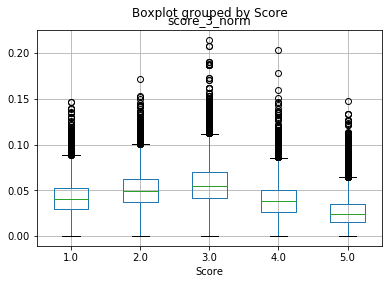

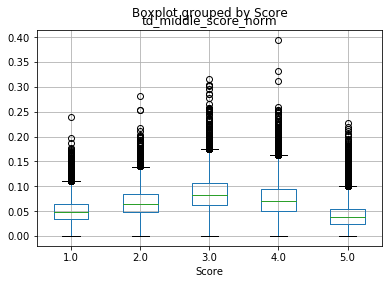

In [76]:
c_big.loc[test.index].boxplot(column='score_3_norm', by='Score')
plt.show()
c_big.loc[test.index].boxplot(column='td_middle_score_norm', by='Score')
plt.show()

In [938]:
c_big['td_middle_score_norm'] = c_big['td_middle_score']/c_big['review_length']
c_big['td_rest_score_norm'] = c_big['td_rest_score']/c_big['review_length']

In [761]:
c_big['tt_pos_score_norm'] = c_big['tt_pos_score']/c_big['review_length']
c_big['tt_neg_score_norm'] = c_big['tt_neg_score']/c_big['review_length']

In [ ]:
c_big['tf_pos_score_norm'] = c_big['tf_pos_score']/c_big['review_length']
c_big['tf_neg_score_norm'] = c_big['tf_neg_score']/c_big['review_length']

In [ ]:
dtm_text_columns = ['o' + str(x) for x in np.arange(dtm_text.shape[1])]
df_dtm_text = pd.DataFrame(dtm_text.todense(), index=c_big.index, 
                                   columns=dtm_text_columns)

In [229]:
c_big[dtm_text_columns] = df_dtm_text

In [19]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50)
svd.fit(dtm_text)
dtm_text_reduced = svd.transform(dtm_text)

In [20]:
dtm_text_reduced_columns = ['t' + str(x) for x in np.arange(dtm_text_reduced.shape[1])]
df_dtm_text_reduced = pd.DataFrame(dtm_text_reduced, index=c_big.index, 
                                   columns=dtm_text_reduced_columns)

## Process review summary

In [15]:
c_big.Summary[c_big.Summary.isnull()] = ""
train.Summary[train.Summary.isnull()] = ""

C:\Users\WeiZhong\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [16]:
vectorizer_summary = CountVectorizer()
vectorizer_summary.fit(train.Summary)
dtm_summary = vectorizer_summary.transform(c_big.Summary)

In [17]:
svd_summary = TruncatedSVD(n_components=20)
svd_summary.fit(dtm_summary)
dtm_summary_reduced = svd_summary.transform(dtm_summary)

In [18]:
dtm_summary_reduced_columns = ['s' + str(x) for x in np.arange(dtm_summary_reduced.shape[1])]
df_dtm_summary_reduced = pd.DataFrame(dtm_summary_reduced, index=c_big.index, 
                                   columns=dtm_summary_reduced_columns)

## Do one-hot encoding of popular products (not included in final forest)

In [11]:
train.ProductId[~train.ProductId.isin(train.ProductId.value_counts()[train.ProductId.value_counts() > 200].index)] = '0'

In [12]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
encoder.fit(train.ProductId)
ProductId_one_hot = encoder.transform(c_big.ProductId)

In [23]:
ProductId_one_hot_columns = ['p' + str(x) for x in np.arange(ProductId_one_hot.shape[1])]
df_ProductId_one_hot = pd.DataFrame(ProductId_one_hot, index=c_big.index, 
                                    columns=ProductId_one_hot_columns)

## Perform classification

In [592]:
c_big = pd.concat([c_big, df_dtm_text, df_ProductId_one_hot, df_dtm_summary_reduced, df_dtm_text_reduced], axis=1)

This cell is for saving the results into a CSV.

In [1]:
import csv
c_big.to_csv('c_big.csv', quoting=csv.QUOTE_ALL)

NameError: name 'c_big' is not defined

This cell is for importing where you left off.

In [4]:
c_big = pd.read_csv('c_big.csv', encoding='latin-1')
c_big.summary_stemmed.fillna("", inplace=True)

In [81]:
rel_columns = ['HelpfulnessDenominator', 'HelpfulnessNumerator', 's_neg_score', 's_pos_score', 'neg_score_norm', 
               'pos_score_norm', 'sd_neg_score', 'sd_pos_score',
               'td_pos_score_norm', 'td_neg_score_norm', 'tt_pos_score_norm', 'tt_neg_score_norm',
               'td_rest_score_norm', 'td_middle_score_norm',
               'score_1_ms_norm', 'score_5_ms_norm',
               'score_2_ms_norm', 'score_3_ms_norm', 'score_4_ms_norm',
               's0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 
               's10', 's11', 's12', 's13', 's14', 's15','s16', 's17', 's18', 's19', 'review_length',
               't0', 't1', 't2', 't3',
               't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14']

In [20]:
train_big = c_big.loc[train.index]

In [265]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor()
mlp.fit(train_big[rel_columns], train.Score)
c_big['prediction_mlp'] = mlp.predict(c_big[rel_columns])
print('train')
print(np.sqrt(mean_squared_error(c_big.Score.loc[train.index], c_big.prediction_mlp.loc[train.index])))
print('test')
print(np.sqrt(mean_squared_error(c_big.Score.loc[test.index], c_big.prediction_mlp.loc[test.index])))

train
0.854949589946
test
0.871284939341


In [ ]:
"""
# This takes very long!!!
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(train_big[rel_columns], train.Score)
c['prediction_knn'] = knn.predict(c_big[rel_columns])
print('train')
print(np.sqrt(mean_squared_error(c_big.Score.loc[train.index], c_big.prediction_knn.loc[train.index])))
print('test')
print(np.sqrt(mean_squared_error(c_big.Score.loc[test.index], c_big.prediction_knn.loc[test.index])))
"""

In [78]:
def discretize(x):
    if x > 4.43:
        return 5
    elif x > 3.40:
        return 4
    elif x > 2.62:
        return 3
    elif x > 1.61:
        return 2
    else:
        return 1

## Here is the random forest that puts everything together:

In [84]:
from sklearn.ensemble import RandomForestClassifier

# with 6-fold validation: still .582
# the k-scores do not seem to help
# with only 1 and 5 k-scores: .585
# without any k-scores: .582
# with k-scores_ms: .584, with k-scores .583
# 200 iter: 0.558
# with score_ms, additional text columns, .5773(91, 88) for all, adjusted threshold
# with explicit scores, 5772(83)
# with score_ms columns, .5772(82) casually - 1 & 5 were impt, no additional text columns
# with middle columns, .6047 casually
# .5967 | 75% train error, 200 iter
# with twograms and threegrams .62 casually ~ .619, .6188 | .61699 with rev texts | 0.6131(55) with text lsas 15 
# with twograms .66 casually... .661 without text LSAs, .674 with text LSAs. 
#  with scores .74
#  without scores .755
#for n_estimators in [5]:#[5,15,20,40,70]:
 #   for min_samples_leaf in [3]:#[1,3,10,20,50]:
cls = RandomForestClassifier(n_estimators = 15, n_jobs = -1,
                                     max_features = 30, min_samples_leaf = 2) # No. of estimators should be 50
cls.fit(c_big.loc[train.index][rel_columns], c_big.loc[train.index].Score)
c_big['prediction_cls'] = cls.predict(c_big[rel_columns])
#c_big['prediction_regressor'] = c_big.prediction_regressor_orig.apply(discretize)
print('n_estimators = {}'.format(15))
print('min_samples_leaf = {}'.format(2))
print('train')
print(np.sqrt(mean_squared_error(c_big.Score.loc[train.index], c_big.prediction_cls.loc[train.index])))
print('test')
print(np.sqrt(mean_squared_error(c_big.Score.loc[test.index], c_big.prediction_cls.loc[test.index])))

n_estimators = 15
min_samples_leaf = 2
train
0.230550371467
test
0.655145040564


In [85]:
df_feature_importances = pd.DataFrame(np.transpose([rel_columns, cls.feature_importances_]))
df_feature_importances[1] = df_feature_importances[1].astype(float)
df_feature_importances.sort_values(1, ascending=False)

,0,1
9,td_neg_score_norm,0.101967
8,td_pos_score_norm,0.097165
13,td_middle_score_norm,0.068487
12,td_rest_score_norm,0.058214
14,score_1_ms_norm,0.043696
10,tt_pos_score_norm,0.043445
2,s_neg_score,0.042250
17,score_3_ms_norm,0.037254
18,score_4_ms_norm,0.033368
11,tt_neg_score_norm,0.027907


In [82]:
from sklearn.ensemble import RandomForestRegressor

# with 6-fold validation: still .582
# the k-scores do not seem to help
# with only 1 and 5 k-scores: .585
# without any k-scores: .582
# with k-scores_ms: .584, with k-scores .583
# 200 iter: 0.558
# with score_ms, additional text columns, .5773(91, 88) for all, adjusted threshold
# with explicit scores, 5772(83)
# with score_ms columns, .5772(82) casually - 1 & 5 were impt, no additional text columns
# with middle columns, .6047 casually
# .5967 | 75% train error, 200 iter
# with twograms and threegrams .62 casually ~ .619, .6188 | .61699 with rev texts | 0.6131(55) with text lsas 15 
# with twograms .66 casually... .661 without text LSAs, .674 with text LSAs. 
#  with scores .74
#  without scores .755
#for n_estimators in [5]:#[5,15,20,40,70]:
 #   for min_samples_leaf in [3]:#[1,3,10,20,50]:
regressor = RandomForestRegressor(n_estimators = 15, n_jobs = -1,
                                     max_features = 30, min_samples_leaf = 2) # No. of estimators should be 50
regressor.fit(c_big.loc[train.index][rel_columns], c_big.loc[train.index].Score)
c_big['prediction_regressor_orig'] = regressor.predict(c_big[rel_columns])
c_big['prediction_regressor'] = c_big.prediction_regressor_orig.apply(discretize)
print('n_estimators = {}'.format(15))
print('min_samples_leaf = {}'.format(2))
print('train')
print(np.sqrt(mean_squared_error(c_big.Score.loc[train.index], c_big.prediction_regressor.loc[train.index])))
print('test')
print(np.sqrt(mean_squared_error(c_big.Score.loc[test.index], c_big.prediction_regressor.loc[test.index])))

n_estimators = 15
min_samples_leaf = 2
train
0.273045327703
test
0.582154024405


In [83]:
df_feature_importances = pd.DataFrame(np.transpose([rel_columns, regressor.feature_importances_]))
df_feature_importances[1] = df_feature_importances[1].astype(float)
df_feature_importances.sort_values(1, ascending=False)

,0,1
9,td_neg_score_norm,0.228953
8,td_pos_score_norm,0.178353
10,tt_pos_score_norm,0.102631
11,tt_neg_score_norm,0.078663
2,s_neg_score,0.071932
14,score_1_ms_norm,0.047476
3,s_pos_score,0.024884
6,sd_neg_score,0.023842
13,td_middle_score_norm,0.021177
7,sd_pos_score,0.018828


In [58]:
from sklearn.ensemble import RandomForestRegressor

# with score_ms columns, .5782 casually - 1 & 5 were impt
# with middle columns, .6047 casually
# .5967 | 75% train error, 200 iter
# with twograms and threegrams .62 casually ~ .619, .6188 | .61699 with rev texts | 0.6131(55) with text lsas 15 
# with twograms .66 casually... .661 without text LSAs, .674 with text LSAs. 
#  with scores .74
#  without scores .755
#for n_estimators in [5]:#[5,15,20,40,70]:
 #   for min_samples_leaf in [3]:#[1,3,10,20,50]:
regressor = RandomForestRegressor(n_estimators = 200, n_jobs = -1,
                                     max_features = 30, min_samples_leaf = 2) # No. of estimators should be 50
regressor.fit(c_big.loc[0:460803][rel_columns], c_big.loc[0:460803].Score)
c_big['prediction_regressor_orig'] = regressor.predict(c_big[rel_columns])
c_big['prediction_regressor'] = c_big.prediction_regressor_orig.apply(discretize)
print('n_estimators = {}'.format(15))
print('min_samples_leaf = {}'.format(2))
print('train')
print(np.sqrt(mean_squared_error(c_big.Score.loc[train.index], c_big.prediction_regressor.loc[train.index])))
print('test')
print(np.sqrt(mean_squared_error(c_big.Score.loc[test.index], c_big.prediction_regressor.loc[test.index])))

n_estimators = 15
min_samples_leaf = 2
train
0.236791290237
test
0.245973468128


In [32]:
df_feature_importances = pd.DataFrame(np.transpose([rel_columns, regressor.feature_importances_]))
df_feature_importances[1] = df_feature_importances[1].astype(float)
df_feature_importances.sort_values(1, ascending=False)

,0,1
8,td_pos_score_norm,0.327626
9,td_neg_score_norm,0.182305
2,s_neg_score,0.073873
10,tt_pos_score_norm,0.062144
14,score_1_ms_norm,0.037117
13,td_middle_score_norm,0.024393
11,tt_neg_score_norm,0.024129
6,sd_neg_score,0.023897
3,s_pos_score,0.019389
7,sd_pos_score,0.017344


In [55]:
from statsmodels.formula.api import ols

mod = ols("Score ~ HelpfulnessDenominator + review_length + neg_score_norm + \
            pos_score_norm", data=c_big[c_big.index.isin(train.index)])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                 4.019e+04
Date:                Sun, 03 Dec 2017   Prob (F-statistic):               0.00
Time:                        20:46:56   Log-Likelihood:            -4.9251e+05
No. Observations:              345603   AIC:                         9.850e+05
Df Residuals:                  345596   BIC:                         9.851e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept         

In [31]:
fractions = np.histogram(c_big.Score[c_big.Score.notnull()], bins=[1,2,3,4,5,6])[0]/sum(c_big.Score.notnull())

In [33]:
cutoffs = np.percentile(c_big.prediction_regressor_orig, np.cumsum(fractions)*100)
cutoffs

array([ 2.18      ,  2.92444444,  3.55888889,  4.24616427,  5.        ])

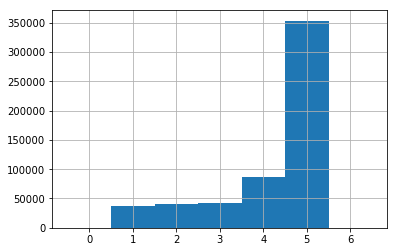

In [856]:
c_big.prediction_regressor_orig.hist(bins=[-.5,.5,1.5,2.5,3.5,4.5,5.5,6.5])
plt.show()

In [ ]:
c_big.prediction_regressor.loc[test.index].hist(bins=[1,2,3,4,5,6], normed=True)
plt.show()

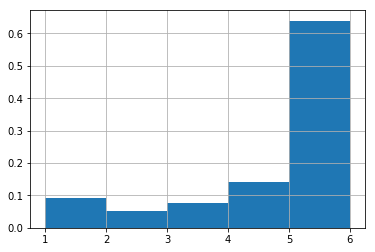

In [769]:
c_big.Score.loc[test.index].hist(bins=[1,2,3,4,5,6], normed=True)
plt.show()

## Final step: Output

In [59]:
c_big.iloc[-100000:][['Id','prediction_regressor']].rename(columns={'prediction_regressor': 'Score'}).to_csv('predictions.csv', index=False)

----